In [ ]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

In [ ]:
# Load the dataset
trade_data = pd.read_csv('/content/TRADES_CopyTr_90D_ROI.csv')

In [ ]:
# Handle missing or malformed data in the Trade_History column
trade_data_clean = trade_data.dropna(subset=['Trade_History'])

In [ ]:
# Parse the 'Trade_History' column (string) into a proper list/dictionary format
import ast
trade_data_clean['Trade_History'] = trade_data_clean['Trade_History'].apply(ast.literal_eval)

<ipython-input-15-4550ce438f03>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trade_data_clean['Trade_History'] = trade_data_clean['Trade_History'].apply(ast.literal_eval)


In [ ]:
# Explode the 'Trade_History' column to create individual trade rows
trade_data_clean['exploded_history'] = trade_data_clean['Trade_History'].apply(lambda x: len(x))
trade_history_normalized = trade_data_clean.explode('Trade_History')

<ipython-input-16-93202cc861af>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trade_data_clean['exploded_history'] = trade_data_clean['Trade_History'].apply(lambda x: len(x))


In [ ]:
# Reset the index to align the Port_IDs correctly after exploding
trade_history_normalized = trade_history_normalized.reset_index(drop=True)

In [ ]:
# Normalize the 'Trade_History' field into separate columns
trade_history_df = pd.json_normalize(trade_history_normalized['Trade_History'])

In [ ]:
# Align Port_IDs with the exploded data
trade_history_df['Port_IDs'] = trade_history_normalized['Port_IDs']

In [ ]:
# Convert 'time' to datetime objects for time-based calculations
trade_history_df['time'] = pd.to_datetime(trade_history_df['time'])



In [42]:
# Create combined positions using 'side' and 'positionSide'
trade_history_df['position'] = trade_history_df['side'] + "_" + trade_history_df['positionSide']

In [43]:
# ROI = (realizedProfit / (quantity * price)) * 100
trade_history_df['investment'] = trade_history_df['quantity'] * trade_history_df['price']
trade_history_df['ROI'] = (trade_history_df['realizedProfit'] / trade_history_df['investment']) * 100

In [44]:
# Total PnL (Profit and Loss)
total_pnl = trade_history_df.groupby('Port_IDs')['realizedProfit'].sum().reset_index()
total_pnl.columns = ['Port_IDs', 'Total_PnL']

In [45]:
# Sharpe Ratio = (mean(return) - risk-free rate) / std(return)
# Assume risk-free rate to be 0 for simplicity in this task
trade_history_df['return'] = trade_history_df['realizedProfit'] / trade_history_df['investment']
sharpe_ratio = trade_history_df.groupby('Port_IDs').apply(lambda x: (x['return'].mean()) / x['return'].std()).reset_index()
sharpe_ratio.columns = ['Port_IDs', 'Sharpe_Ratio']

<ipython-input-45-652cc25cc585>:4: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = trade_history_df.groupby('Port_IDs').apply(lambda x: (x['return'].mean()) / x['return'].std()).reset_index()


In [46]:
# Maximum Drawdown (MDD)
def calculate_mdd(returns):
    cumulative = (1 + returns).cumprod()
    high_watermark = cumulative.cummax()
    drawdown = (cumulative - high_watermark) / high_watermark
    return drawdown.min()

mdd = trade_history_df.groupby('Port_IDs').apply(lambda x: calculate_mdd(x['return'])).reset_index()
mdd.columns = ['Port_IDs', 'MDD']

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: RuntimeWarning: overflow encountered in accumulate
  return bound(*args, **kwds)


In [47]:
# Win Rate = Number of profitable trades / Total trades
win_positions = trade_history_df[trade_history_df['realizedProfit'] > 0].groupby('Port_IDs').size().reset_index(name='Win_Positions')
total_positions = trade_history_df.groupby('Port_IDs').size().reset_index(name='Total_Positions')
win_rate = win_positions.merge(total_positions, on='Port_IDs', how='outer').fillna(0)
win_rate['Win_Rate'] = win_rate['Win_Positions'] / win_rate['Total_Positions']

In [48]:
# Step 3: Merge Metrics into a Single DataFrame
metrics_df = total_pnl.merge(sharpe_ratio, on='Port_IDs').merge(mdd, on='Port_IDs').merge(win_rate, on='Port_IDs')

In [49]:
# Step 4: Ranking Accounts Based on Combined Score
# Create a weighted score based on metrics
metrics_df['score'] = (metrics_df['Total_PnL'] * 0.4) + (metrics_df['Sharpe_Ratio'] * 0.3) + \
                      ((1 + metrics_df['MDD']) * -0.2) + (metrics_df['Win_Rate'] * 0.1)

In [50]:
# Rank accounts based on score
metrics_df['Rank'] = metrics_df['score'].rank(ascending=False)
top_20_accounts = metrics_df.sort_values('Rank').head(20)

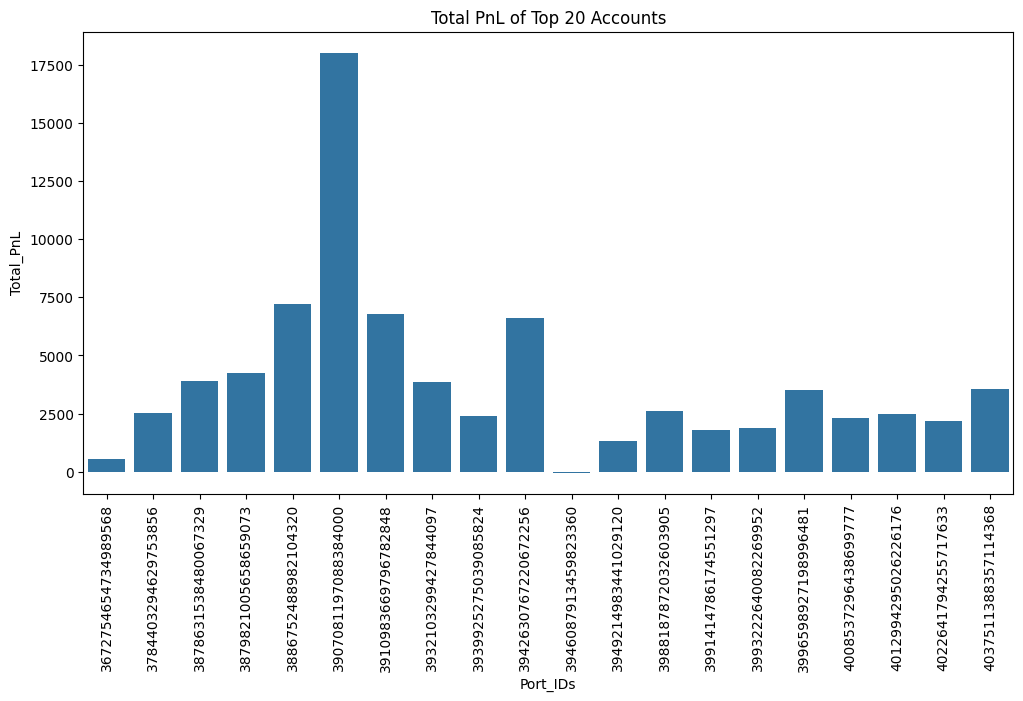

In [51]:
# Step 5: Visualizations

# Visualization of top 20 accounts' Total PnL
plt.figure(figsize=(12, 6))
sns.barplot(x='Port_IDs', y='Total_PnL', data=top_20_accounts)
plt.title('Total PnL of Top 20 Accounts')
plt.xticks(rotation=90)
plt.show()

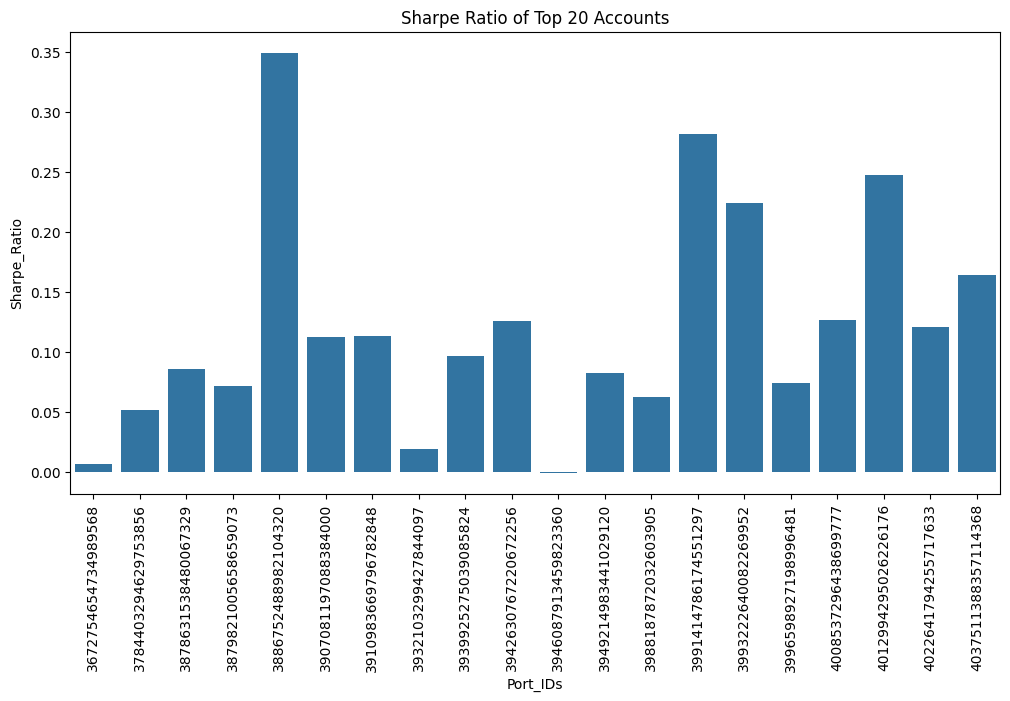

In [52]:
# Visualization of Sharpe Ratio for top 20 accounts
plt.figure(figsize=(12, 6))
sns.barplot(x='Port_IDs', y='Sharpe_Ratio', data=top_20_accounts)
plt.title('Sharpe Ratio of Top 20 Accounts')
plt.xticks(rotation=90)
plt.show()

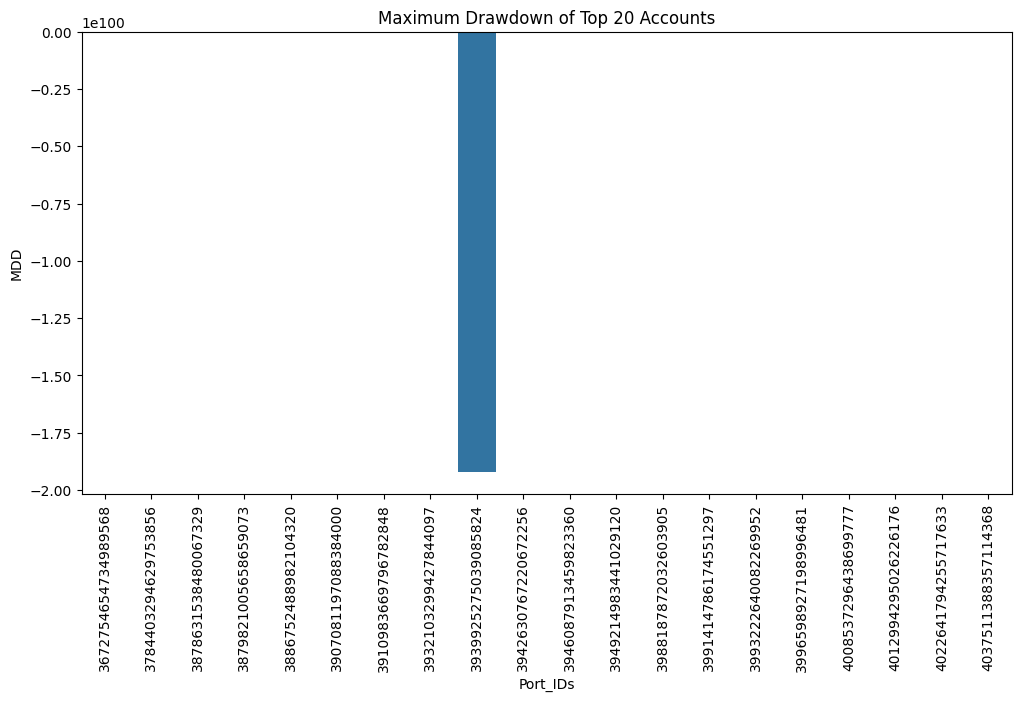

In [53]:
# Visualization of Maximum Drawdown for top 20 accounts
plt.figure(figsize=(12, 6))
sns.barplot(x='Port_IDs', y='MDD', data=top_20_accounts)
plt.title('Maximum Drawdown of Top 20 Accounts')
plt.xticks(rotation=90)
plt.show()

In [54]:
# Save the final metrics dataframe and top 20 list to CSV
metrics_df.to_csv('calculated_metrics.csv', index=False)
top_20_accounts.to_csv('top_20_accounts.csv', index=False)